# Analysis of the AMLTK Pipeline
OpenFE-like Analysis

### To Do for the User

In [275]:
# TODO 1 for the user: Adapt list of labels (has to correspond to the method names for which the AMLTK was executed in the src/amtlk/main.py main()-method
label_list = ['Original Data', 'autofeat Data', 'OpenFE Data', 'AutoGluon']
# TODO 2 for the user: Adjust part size number according to the max_trials variable defined in src/amltk/main.py
part_size = 10
# TODO 3 for the user: Define the names of the used datasets
# all 10 datasets
datasets = ["abalone dataset", "moneyball dataset", "australian dataset", "blood transfusion service center dataset", "car dataset", "churn dataset", "credit g dataset", "kr-vs-kp dataset", "pc4 dataset", "wilt dataset"]#, "wine-quality-white dataset"]
# 5 small datasets
# datasets = ["australian dataset", "blood transfusion service center dataset", "car dataset", "credit g dataset", "wilt dataset"]
# 1 dataset to test new methods
# datasets = ['blood transfusion service center dataset']
# TODO 4 for the user. Define number of folds
folds = 1

### Imports


In [276]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [277]:
df_all = pd.DataFrame(columns=['Dataset', 'Type', 'Fold', 'Value'])

# Process the data
for dataset in datasets:
    for fold in range(folds):
        dataset_string = dataset.replace(" ", "_").replace("-", "_")
        df_fold = pd.read_parquet(f"results_{dataset_string}_fold_{fold}.parquet")

        for i, label in enumerate(label_list):
            metric_accuracy = df_fold["metric:accuracy [0.0, 1.0] (maximize)"].tolist()
            metric_accuracy = [sum(metric_accuracy[x:x+part_size]) for x in range(0, len(metric_accuracy), part_size)]

            # Only add value if lengths match
            if len(metric_accuracy) == len(label_list):
                value = metric_accuracy[i]
                df_all = df_all._append({'Dataset': dataset, 'Type': label, 'Fold': fold, 'Value': value}, ignore_index=True)
                

In [278]:
# Standard Deviation
df_stddev = df_all.groupby(['Dataset', 'Type'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Type'])['Value'].mean().reset_index().fillna(0)

In [279]:
# Add standard deviation to the averages values
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)

In [280]:
# Print and write to file
pivot_table = df_summary.pivot(index='Dataset', columns='Type', values='Value_with_StdDev').fillna('0 ± 0')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('tabular_data.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+---+------------------------------------------+-------------------------+--------------------------+-------------------------+--------------------------+-------------------------+------------------------------+-------------------------+
|   |                 Dataset                  |        AutoGluon        |           H2O            |          MLJAR          |       OpenFE Data        |      Original Data      | Self-feature-engineered Data |      autofeat Data      |
+---+------------------------------------------+-------------------------+--------------------------+-------------------------+--------------------------+-------------------------+------------------------------+-------------------------+
| 0 |             abalone dataset              | 0.472740779385746 ± 0.0 | 2.4448526743183776 ± 0.0 | 2.517729551331489 ± 0.0 | 2.4522926779476477 ± 0.0 | 2.539019189765458 ± 0.0 |   2.522525291475752 ± 0.0    | 2.545399333121626 ± 0.0 |
| 1 |            australian dataset            |

### Boxplots

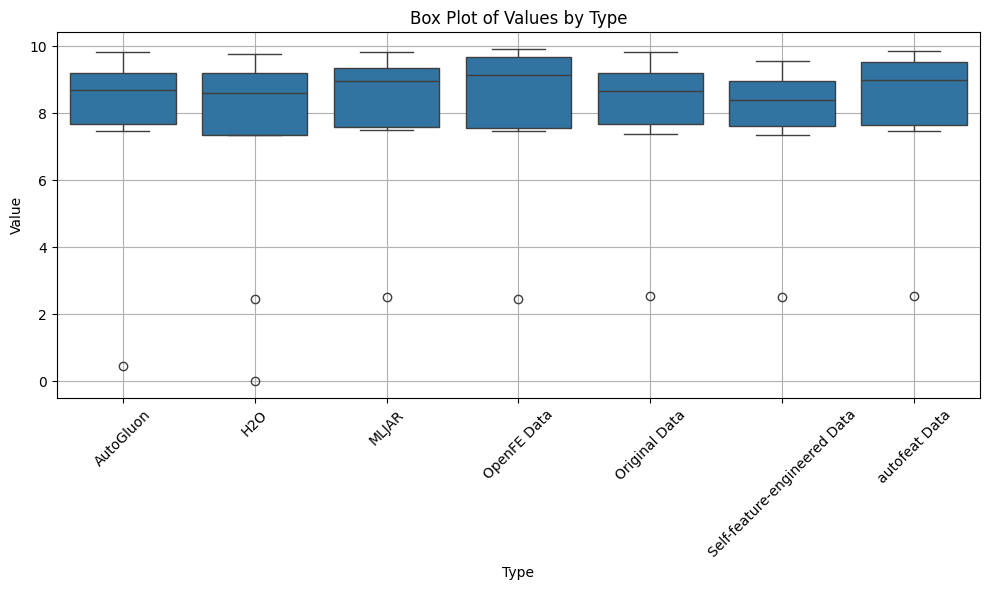

In [281]:
# Extract values
def extract_value(value_with_stddev):
    value, _ = value_with_stddev.split(' ± ')
    return float(value)

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset'], var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Value', data=melted_df)
plt.xlabel("Type")
plt.ylabel("Value")
plt.title("Box Plot of Values by Type")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()